In [2]:
import json
import math
import os
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split

from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG16
from keras.utils.np_utils import to_categorical
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization
import tensorflow as tf

In [18]:
input_dir = "D:\Desktop\Projects\Pneumonia_xrays\chest_xray"
train_dir = input_dir +"\\train/"
test_dir = input_dir +"\\test/"
val_dir = input_dir +"\\val/"

In [20]:
train_datagen = ImageDataGenerator(
                                rescale=1/255.0,
                               horizontal_flip=True,
                               zoom_range=0.2,
                               shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(224,224),
        batch_size=16,
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [21]:
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in vgg.layers:
    layer.trainable = False #making all the layers non-trainable
    
x = Flatten()(vgg.output) #flattening out the last layer
predictions = Dense(2,activation='softmax')(x) #Dense layer to predict wether their is pneumonia or not
model = Model(inputs=vgg.input, outputs=predictions)
model.summary()

58892288/58889256 [==============================] - 9s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_______________________________________________________

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hist = model.fit_generator(train_generator,
        steps_per_epoch=25,
        epochs=25,
        validation_data=test_generator,
        validation_steps=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
25/25 [==============================] - 24s 945ms/step - loss: 0.4751 - accuracy: 0.8075 - val_loss: 0.5398 - val_accuracy: 0.7750
Epoch 2/25
25/25 [==============================] - 21s 828ms/step - loss: 0.1720 - accuracy: 0.9250 - val_loss: 0.3209 - val_accuracy: 0.9000
Epoch 3/25
25/25 [==============================] - 18s 723ms/step - loss: 0.1730 - accuracy: 0.9300 - val_loss: 0.2783 - val_accuracy: 0.8875
Epoch 4/25
25/25 [==============================] - 19s 758ms/step - loss: 0.1566 - accuracy: 0.9375 - val_loss: 0.2127 - val_accuracy: 0.9375
Epoch 5/25
25/25 [==============================] - 18s 735ms/step - loss: 0.1982 - accuracy: 0.9375 - val_loss: 0.4144 - val_accuracy: 0.8687
Epoch 6/25
25/25 [==============================] - 18s 723ms/step - loss: 0.1354 - accuracy: 0.9525 - val_loss: 0.2998 - val_accuracy: 0.9062
Epoch 7/25
25/25 [==============================] - 17s 670ms/step

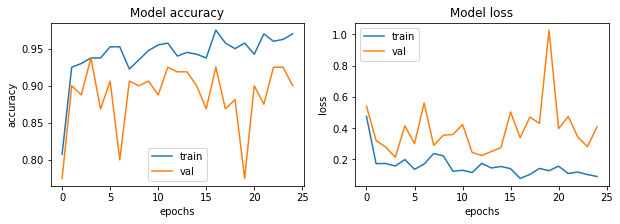

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))


for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
model.save('modelvgg16.h5')

In [26]:
avg = np.mean(hist.history['accuracy'])
print('The Average Training Accuracy is', avg)

The Average Training Accuracy is 0.9427999973297119
